In this example I demonstrate how to compute the log-probability of a sample output from an ODE. Consider an ODE that evolves like the following from t=0 to t=1, and the initial value is sampled from a standard normal.

$$[\overset{.}{z_0}; \overset{.}{z_1}] =  \begin{bmatrix} 0.2203& 0.3234\\  0.4713 & 0.2240\end{bmatrix} [z_1; z_2]$$ 

The output is going to be a heteroscedastic MVN. We can compute the log-probability using an integrator and thm 1 and then plot the contours of the log-pdf returned by ODE and also compare the log-pdf with the KDE estimates

In [20]:
from torchdiffeq import odeint, odeint_adjoint
import torch
from torch import tensor, stack, exp
from scipy.stats import multivariate_normal 
mvn = multivariate_normal([0,0])

def trace(w):
    return w[0,0] + w[1,1]

W = [[0.2203, 0.3234], [0.4713, 0.2240]]
class ODEFunc(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w = torch.nn.Parameter(tensor(W))
        
    def forward(self, t, state):
        v = torch.cat(
            [torch.mv(self.w, state[:2]) * exp(-0.1 * t),
             (trace(self.w) * exp(-0.1 * t))[None]
            ])
        return v

def get_z0():
    z = torch.randn(2)
    l = mvn.logpdf(z.tolist())
    return torch.tensor([z[0], z[1], l])

T_initial, T_final = 0, 1
t_series = torch.linspace(T_initial, T_final, 2)

In [30]:
from tqdm.notebook import tqdm
ode = ODEFunc()
Z = []
for sample in tqdm(range(4000)):
    z0p = get_z0()
    ztp = odeint(ode, z0p, t_series)
    Z.append(ztp[-1].tolist())


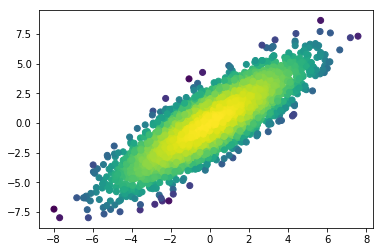

In [49]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
x, y, logp = zip(*Z)
plt.scatter(x, y, c=logp)

In [33]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(
    [e[:2] for e in Z])

In [36]:
kde_log_prob = kde.score_samples([e[:2] for e in Z])
node_log_prob = [e[2] for e in Z]

Note that KDE over-estimates the probability of rare events. That's why the KDE estimated are higher towards the left hand side of the plot.

Text(0, 0.5, 'Log prob computed by KDE')

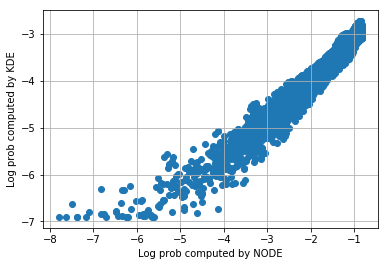

In [41]:
plt.scatter(node_log_prob, kde_log_prob)
plt.grid(True)
plt.xlabel('Log prob computed by NODE')
plt.ylabel('Log prob computed by KDE')